In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob

In [3]:
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack, unique
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget.targets      import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations
from    desisurvey.utils        import  get_date
from    desitarget.sv1          import  sv1_cuts 

In [4]:
##  DR7 cutouts
import  requests

from    PIL                     import  Image
from    io                      import  BytesIO

In [5]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/utils_specviewer.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]

In [7]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0) + 0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    
    return  mag

##  DR7 cutouts 

In [8]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

In [9]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
version = 'v2'
root    = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/{}/'.format(version)

## Prep. redrock templates

In [10]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [11]:
cframes = Table(fits.open('/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_{}_gfa.fits'.format(version))[1].data) 
cframes

NIGHT,MJD,LAT,LON,ELV,TILEID,EXPID,EXPTIME,CAMERA,PROGRAM,PETAL_LOC,SPECGRPH,RA,DEC,MOON_ALT,MOON_RA,MOON_DEC,MOON_FRAC,MOON_SEP,SUN_ALT,SUN_RA,SUN_DEC,SUN_SEP,AIRMASS,EBV,MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,SKY_MAG_AB,SKY_MAG_AB_PER_AMP,SKYRA,SKYDEC,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,CUBE_INDEX,RACEN,DECCEN,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP,OVERSCAN_MEDIANS_ADU,PRESCAN_MEDIANS_ADU,FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS,CD,CDELT,CRPIX,CRVAL,LONGPOLE,LATPOLE,PV2,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP,DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS,DARK_RESCALE_CONVERGED
str40,float64,float64,float64,float64,int64,int64,float64,str40,str40,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,31.96403,-111.59989,2097.0,70502,52090,900.0,b,SV tile 70502,0,0,180.012,-0.510261,-34.718022305904064,6.5807533473741975,-2.8514428140522536,0.0627905403740725,172.62306614298288,-58.985404389203396,338.8184557889157,-8.90282836156349,156.88472549965033,1.6491293775976599,0.031056919357460633,1498.5,1498.71237064332,0.0,14171.5,1305.5,74.1301109252801,74.1301109252801,1510.5,1512.1791519046753,0.0,6803.5,1436.0,10.378215529539215,10.378215529539215,1448.0,1453.5707260250122,0.0,13751.0,1386.0,10.378215529539215,10.378215529539215,1506.5,1508.7537964813469,0.0,7934.5,1429.0,12.602118857297617,12.602118857297617,1377.0,1381.3672603636749,0.0,7951.5,1305.5,11.119516638792016,11.119516638792016,21.166722602992905,21.162157,180.012,-0.510261,6.887381,-2.523766,9.646,0.0,5.0,62.0,179.99966051964955,-0.5499658695163923,3.8426876448623024,0.15819694491469147,4.0,0.4802858062435611,24.880265561743073,24.893638934214035,172.3655579744284,25.4973871698881,0.9372713127978513,0.0,0.0,1407.0,1394.0,12.65485591453827,11.17607840033076,11.847539901733398,2.4287456798553464,11.0,1540.0,2.0343276314399996e-08,1.0,16266.06196518,89.7508695,180.0,90.0,0.0,1.0,5.0,10.07,0.887832033298626,4.692542112685003,1.0497448730468755,1.050003051757813,1.050003051757813,1.0,36.0,1.0
20200225,58905.29573492,31.96403,-111.59989,2097.0,70502,52112,900.0,b,SV tile 70502,0,0,180.006929,-0.50838,-44.78323495364497,7.13291666046073,-2.6659189741928837,0.06456711009394417,172.20097121173714,-65.64763237733636,338.8556693565404,-8.888320131591259,156.92963241839925,1.369023183589419,0.0312053262371375,1499.0,1499.251294276511,0.0,15046.0,1307.0,73.3888098160273,73.3888098160273,1511.0,1512.3986986736918,0.0,6854.5,1438.0,10.378215529539215,10.378215529539215,1448.5,1453.66285125969,0.0,14277.5,1389.0,11.860817748044816,11.860817748044816,1508.0,1510.5980640973232,0.0,8373.5,1431.0,12.602118857297617,12.602118857297617,1378.0,1

In [12]:
# BGS EXPIDS:  defined by night and tile.
bgs_expids = cframes['EXPID']
nights     = cframes['NIGHT'] 
tiles      = cframes['TILEID']
petals     = cframes['PETAL_LOC']

##  Unique tiles and nights.

In [13]:
samples    = OrderedDict(set(zip(nights, tiles)))
order      = np.sort([np.int(x) for x in samples.keys()]).astype(str)

samples    = OrderedDict(zip(order, [samples[x] for x in order]))
samples    = list(zip(samples.keys(), samples.values()))
samples

[('20200225', 70502),
 ('20200227', 70502),
 ('20200228', 70500),
 ('20200303', 70500)]

In [14]:
# MOONRA, MOONDEC, MOON_SEP_DEG
attributes = ['MOON_ALT', 'MOON_RA', 'MOON_DEC', 'MOON_FRAC', 'MOON_SEP', 'SUN_ALT',\
              'SUN_RA', 'SUN_DEC', 'SUN_SEP', 'EXPTIME', 'AIRMASS']

# 'SKY_MAG_AB', 'FIBER_FRACFLUX', 'MOON_SEP_DEG', 'TRANSPARENCY', 'FWHM_ASEC']

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

##   GET COADDED EXPOSURES AND ZBEST FILES

In [15]:
utiles                     = np.unique(tiles)
upetals                    = np.array([0,3,6,7,9])
unights                    = np.unique(nights)

In [16]:
# https://github.com/desihub/desispec/blob/c544749a8ab4b982a054b91247f056c2ce4bd8ce/py/desispec/specscore.py#L148 
bandpasses                 = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}

fpath                      = root + '/NEXP1/{}/{}/coadd-{}-0-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

results                    = OrderedDict()

for tile in utiles:
    results[tile]          = OrderedDict()

for i, (night, tile) in enumerate(samples):
      results[tile][night] = OrderedDict()

      for ncoadd in [1, 2, 4, 'ALL']:
        ##  E.g.  coadd-20200303-6-2expc.fits
        ##        coadd-20200303-3-00052933.fits 
        ##
        ##        coadd-20200303-6-3exp-subset-2.fits
        if ncoadd in [1, 2, 4]:
          look               =  glob.glob(root + '/NEXP{}/{}/{}/coadd-*'.format(ncoadd, tile, night)) 
          subsets            = [x.split('-')[-1].replace('.fits', '') for x in look]
          subsets            =  np.array([int(x) for x in subsets])                
   
          try:
            maxn_splits      = subsets.max()

          except:
            print('{}    No coadd available for tile {} night {} and ncoadd {} ({})'.format(str(datetime.datetime.now()), tile, night, ncoadd, subsets))

            key                                    = 'NEXP' + str(ncoadd)
            
            results[tile][night][key]              = None
          
            continue
     
          if ncoadd == 1:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(x) for x in subsets]

          else:
            keys                                   = ['NEXP' + str(ncoadd) + '-' + str(nsplit) for nsplit in range(maxn_splits)]      

          nsplits                                  =  list(range(maxn_splits))
    
        elif ncoadd == 'ALL':
          keys                                     = ['ALL']
          nsplits                                  = [-99]

        else:
          raise  ValueError('Problem.')
                 
        for key, nsplit in zip(keys, nsplits): 
          results[tile][night][key]                 = {}
        
          results[tile][night][key]['coadds']       = []
          results[tile][night][key]['coadds_flux']  = []
          results[tile][night][key]['coadds_ivar']  = []
          results[tile][night][key]['coadds_mask']  = []
          results[tile][night][key]['coadds_res']   = []
          results[tile][night][key]['fiberstatus']  = []
          results[tile][night][key]['zbests']       = []
                
          results[tile][night][key]['scores']       = []
            
          results[tile][night][key]['coadds_paths'] = {}
          results[tile][night][key]['zbests_paths'] = {}
          
          for petal in upetals:
            print('{}    Solving for tile {}, night {}, key {}, petal {} and ncoadd {}.'.format(str(datetime.datetime.now()), tile, night, key, petal, ncoadd))
            
            if key == 'ALL':
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal) 
              zbest_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal).replace('coadd', 'zbest')
            
            elif key.split('-')[0] == 'NEXP1':
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1]))
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{:08d}.fits'.format(ncoadd, tile, night, night, petal, np.int(key.split('-')[-1])).replace('coadd', 'zbest')
            
            else:
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit) 
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit).replace('coadd', 'zbest')
            
            results[tile][night][key]['coadds_paths'][petal] = coadd_path
            results[tile][night][key]['zbests_paths'][petal] = zbest_path
            
            try:
              coadd = fitsio.read(coadd_path)
              zbest = fitsio.read(zbest_path)
    
            except:
              results[tile][night][key]['coadds_paths'][petal] = None
              results[tile][night][key]['zbests_paths'][petal] = None
            
              continue
    
            results[tile][night][key]['coadds'].append(coadd)  
            results[tile][night][key]['zbests'].append(zbest)
    
            _ = fitsio.read(coadd_path, ext=2) 
         
            assert  np.all(np.isclose(wave, _))
        
            results[tile][night][key]['coadds_flux'].append(fitsio.read(coadd_path, ext=3)) 
            results[tile][night][key]['coadds_ivar'].append(fitsio.read(coadd_path, ext=4))
            results[tile][night][key]['coadds_mask'].append(fitsio.read(coadd_path, ext=5))
            results[tile][night][key]['coadds_res'].append(fitsio.read(coadd_path,  ext=6))
            results[tile][night][key]['fiberstatus'].append(fitsio.read(coadd_path, ext=1)['FIBERSTATUS'])
        
            results[tile][night][key]['scores'].append(fitsio.read(coadd_path,  ext=7))

          ##
          results[tile][night][key]['coadds']      = np.hstack(results[tile][night][key]['coadds'])
          results[tile][night][key]['zbests']      = np.hstack(results[tile][night][key]['zbests'])
          results[tile][night][key]['coadds_flux'] = np.vstack(results[tile][night][key]['coadds_flux'])
          results[tile][night][key]['coadds_ivar'] = np.vstack(results[tile][night][key]['coadds_ivar'])
          results[tile][night][key]['coadds_mask'] = np.vstack(results[tile][night][key]['coadds_mask']) 
          results[tile][night][key]['coadds_res']  = np.vstack(results[tile][night][key]['coadds_res'])
          results[tile][night][key]['fiberstatus'] = np.hstack(results[tile][night][key]['fiberstatus'])
        
          results[tile][night][key]['scores']      = np.vstack(results[tile][night][key]['scores'])
  
          dat                                      = fits.open(coadd_path)

          ids_incoadd                              = np.unique([np.int(dat[0].header['INFIL*'][x].split('-')[-1].replace('.fits', '')) for x in range(len(dat[0].header['INFIL*']))])
            
          keep                                     = [x in ids_incoadd for x in cframes['EXPID']]   
          _                                        =  cframes[keep]
    
          for attribute in attributes: 
              results[tile][night][key][attribute.upper()] = np.array(_[attribute]).astype(np.float).mean()

          if key == 'ALL':            
            results[tile][night]['ALL-NEXP{}'.format(len(ids_incoadd))] = results[tile][night].pop(key)
                
          ##  for key in ['coadds', 'zbests', 'coadds_flux', 'coadds_ivar', 'coadds_mask', 'coadds_res']:
          ##    print(results[tile][night][key].shape)
        
print('\n\nDone.\n\n')

2020-03-12 18:50:18.940267    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 0 and ncoadd 1.
2020-03-12 18:50:19.660432    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 3 and ncoadd 1.
2020-03-12 18:50:20.299300    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 6 and ncoadd 1.
2020-03-12 18:50:21.006215    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 7 and ncoadd 1.
2020-03-12 18:50:21.615965    Solving for tile 70502, night 20200225, key NEXP1-52115, petal 9 and ncoadd 1.
2020-03-12 18:50:23.210620    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 0 and ncoadd 1.
2020-03-12 18:50:23.911739    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 3 and ncoadd 1.
2020-03-12 18:50:24.628546    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 6 and ncoadd 1.
2020-03-12 18:50:26.293675    Solving for tile 70502, night 20200225, key NEXP1-52114, petal 7 and ncoadd 1.
2020-03-12 18:50:26

In [17]:
nkeys = 0

for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()

  print('------------- {} -------------- {} ------------------'.format(night, tile))
  print(keys)
  print('\n')
    
  nkeys += len(keys)

nkeys

------------- 20200225 -------------- 70502 ------------------
odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL-NEXP6'])


------------- 20200227 -------------- 70502 ------------------
odict_keys(['NEXP1-52447', 'NEXP1-52448', 'NEXP4', 'ALL-NEXP2'])


------------- 20200228 -------------- 70500 ------------------
odict_keys(['NEXP1-52636', 'NEXP1-52630', 'NEXP4', 'ALL-NEXP2'])


------------- 20200303 -------------- 70500 ------------------
odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL-NEXP12'])




37

##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [18]:
# 'MOON_SEP_DEG', 'TRANSPARENCY', 'SKY_MAG_AB', 'FIBER_FRACFLUX', 'FWHM_ASEC'.
print_cols                = ['EXPTIME', 'MOON_FRAC', 'MOON_ALT', 'MOON_SEP', 'AIRMASS', 'SUN_ALT', 'SUN_SEP']

toprint                   = {}

toprint['NIGHT']          = []
toprint['TILE']           = []
toprint['NEXP']           = []

for x in print_cols:
  toprint[x]              = []

toprint['IS_GOOD']        = []
toprint['IS_BGS']         = []
toprint['IS_GOOD_BGS']    = []
toprint['IS_ZGOOD_BGS']   = []
toprint['IS_ZGOOD_BGS_%'] = []
toprint['IS_GOOD_MAIN']   = []
toprint['IS_ZGOOD_MAIN']  = []
toprint['IS_GOOD_FAINT']  = []
toprint['IS_ZGOOD_FAINT'] = []
toprint['IS_GOOD_LOWQ']   = []
toprint['IS_ZGOOD_LOWQ']  = []
toprint['IS_GOOD_FIB']    = []
toprint['IS_ZGOOD_FIB']   = []

for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if results[tile][night][key] == None:
        continue
        
    isgood                    = (results[tile][night][key]['fiberstatus'] == 0)

    coadds                    =  results[tile][night][key]['coadds']
    zbest                     =  results[tile][night][key]['zbests']
     
    IS_SV0                    = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_GOOD_BGS               = IS_SV0 & isgood
    IS_GOOD_MAIN              = IS_GOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)
    
    # Exclude QSOs (lack of redshift precision for small scales).
    IS_ZGOOD_BGS              = IS_GOOD_BGS  & (zbest['ZWARN'] == 0) & (zbest['SPECTYPE'] == b'GALAXY') 
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS & (zbest['ZERR'] < 0.0005 * (1. + zbest['Z']))
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS
    
    IS_ZGOOD_MAIN             = IS_ZGOOD_BGS & ((coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0)
    
    ##
    sv_types                  = ['bright', 'faint', 'faint_ext', 'lowq', 'fibmag']
    bgs_subsample             = {}
    
    for targtype in sv_types:      
      # No extinction. 
      rmag = flux2mag(coadds['FLUX_R'])
      grr  = coadds['GAIA_PHOT_G_MEAN_MAG'] - rmag                                                                                
        
      bgs_subsample[targtype.upper()] =  sv1_cuts.isBGS(gflux=coadds['FLUX_G'] / coadds['MW_TRANSMISSION_G'],\
                                                        rflux=coadds['FLUX_R'] / coadds['MW_TRANSMISSION_R'],\
                                                        zflux=coadds['FLUX_Z'] / coadds['MW_TRANSMISSION_Z'],\
                                                        w1flux=coadds['FLUX_W1'] / coadds['MW_TRANSMISSION_W1'],\
                                                        w2flux=coadds['FLUX_W2'] / coadds['MW_TRANSMISSION_W2'],\
                                                        rfiberflux=coadds['FIBERFLUX_R']/ coadds['MW_TRANSMISSION_R'],\
                                                        gnobs=coadds['NOBS_G'],\
                                                        rnobs=coadds['NOBS_R'],\
                                                        znobs=coadds['NOBS_Z'],\
                                                        gfracmasked=coadds['FRACMASKED_G'],\
                                                        rfracmasked=coadds['FRACMASKED_R'],\
                                                        zfracmasked=coadds['FRACMASKED_Z'],\
                                                        gfracflux=coadds['FRACFLUX_G'],\
                                                        rfracflux=coadds['FRACFLUX_R'],\
                                                        zfracflux=coadds['FRACFLUX_Z'],\
                                                        gfracin=coadds['FRACIN_G'],\
                                                        rfracin=coadds['FRACIN_R'],\
                                                        zfracin=coadds['FRACIN_Z'],\
                                                        gfluxivar=coadds['FLUX_IVAR_G'],\
                                                        rfluxivar=coadds['FLUX_IVAR_R'],\
                                                        zfluxivar=coadds['FLUX_IVAR_Z'],\
                                                        maskbits=coadds['MASKBITS'],\
                                                        Grr=grr,\
                                                        w1snr=None,\
                                                        gaiagmag=coadds['GAIA_PHOT_G_MEAN_MAG'],\
                                                        objtype=coadds['MORPHTYPE'],\
                                                        primary=None,\
                                                        south=False,\
                                                        targtype=targtype)
    
    toprint['NIGHT'].append(night)
    toprint['TILE'].append(tile)
    toprint['NEXP'].append(key.ljust(8))
    
    for x in print_cols:
      toprint[x].append(results[tile][night][key][x])

    toprint['IS_GOOD'].append(np.count_nonzero(isgood))
    toprint['IS_BGS'].append(np.count_nonzero(IS_SV0))
    toprint['IS_GOOD_BGS'].append(np.count_nonzero(IS_GOOD_BGS))
    toprint['IS_ZGOOD_BGS'].append(np.count_nonzero(IS_ZGOOD_BGS))
    toprint['IS_ZGOOD_BGS_%'].append(100. * np.float(np.count_nonzero(IS_ZGOOD_BGS)) / np.float(np.count_nonzero(IS_GOOD_BGS)))
    toprint['IS_GOOD_MAIN'].append(np.count_nonzero(IS_GOOD_MAIN))
    toprint['IS_ZGOOD_MAIN'].append(np.count_nonzero(IS_ZGOOD_MAIN))  
    
    toprint['IS_GOOD_FAINT'].append(np.count_nonzero(bgs_subsample['FAINT']  & IS_GOOD_BGS))
    toprint['IS_ZGOOD_FAINT'].append(np.count_nonzero(bgs_subsample['FAINT']  & IS_ZGOOD_BGS))
    
    toprint['IS_GOOD_LOWQ'].append(np.count_nonzero(bgs_subsample['LOWQ']  & IS_GOOD_BGS))
    toprint['IS_ZGOOD_LOWQ'].append(np.count_nonzero(bgs_subsample['LOWQ']  & IS_ZGOOD_BGS))
    
    toprint['IS_GOOD_FIB'].append(np.count_nonzero(bgs_subsample['FIBMAG']  & IS_GOOD_BGS))
    toprint['IS_ZGOOD_FIB'].append(np.count_nonzero(bgs_subsample['FIBMAG']  & IS_ZGOOD_BGS))

    results[tile][night][key]['IS_BGS']       = IS_SV0
    results[tile][night][key]['IS_GOOD_BGS']  = IS_GOOD_BGS
    results[tile][night][key]['IS_ZGOOD_BGS'] = IS_ZGOOD_BGS 
    
##  
_ = pd.DataFrame()

for x in toprint.keys():
  try:
    _[x] = np.array(toprint[x])
    
  except:
    print('Failed for {}'.format(x))
_

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packag

,NIGHT,TILE,NEXP,EXPTIME,MOON_FRAC,MOON_ALT,MOON_SEP,AIRMASS,SUN_ALT,SUN_SEP,...,IS_ZGOOD_BGS,IS_ZGOOD_BGS_%,IS_GOOD_MAIN,IS_ZGOOD_MAIN,IS_GOOD_FAINT,IS_ZGOOD_FAINT,IS_GOOD_LOWQ,IS_ZGOOD_LOWQ,IS_GOOD_FIB,IS_ZGOOD_FIB
0,20200225,70502,NEXP1-52115,900.0,0.066733,-54.733052,171.637603,1.217957,-65.621309,156.981431,...,1169,91.686275,746,729,258,228,10,2,65,49
1,20200225,70502,NEXP1-52114,900.0,0.066048,-51.968526,171.820477,1.250062,-66.729890,156.965316,...,1179,92.470588,746,732,258,232,10,2,65,51
2,20200225,70502,NEXP1-52113,900.0,0.065315,-48.586919,172.011711,1.299431,-66.796778,156.947803,...,1179,92.470588,746,729,258,235,10,1,65,55
3,20200225,70502,NEXP1-52116,900.0,0.067458,-57.144716,171.440369,1.196743,-63.508533,156.998249,...,1154,90.509804,746,721,258,223,10,3,65,50
4,20200225,70502,NEXP1-52112,900.0,0.064567,-44.783235,172.200971,1.369023,-65.647632,156.929632,...,1180,92.621664,745,728,258,232,10,1,65,53
5,20200225,70502,NEXP1-52090,900.0,0.062791,-34.718022,172.623066,1.649129,-58.985404,156.884725,...,1175,92.446892,742,727,258,236,10,2,65,52
6,20200225,70502,NEXP2-0,900.0,0.064419,-43.343274,172.221772,1.449596,-62.857647,156.925021,...,1214,95.141066,747,734,258,247,10,2,65,56
7,20200225,70502,NEXP2-1,900.0,0.066024,-51.659986,171.824657,1.258694,-66.209043,156.964617,...,1215,95.219436,747,733,258,247,10,1,65,56
8,20200225,70502,ALL-NEXP6,900.0,0.065485,-48.655745,171.955699,1.330391,-64.548258,156.951193,...,1240,97.178683,747,737,258,253,10,3,65,61
9,20200227,70502,NEXP1-52447,500.0,0.191811,-44.570970,149.349464,1.191672,-56.964642,159.040389,...,640,50.196078,746,450,258,103,10,1,65,30


(0.0, 1.25)

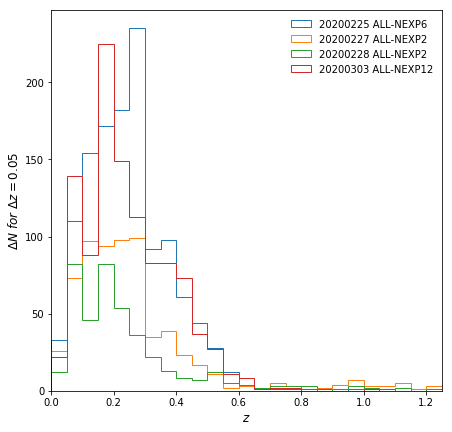

In [19]:
plt.rcParams['figure.figsize'] = [7, 7]

dz = 0.05

for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if key.split('-')[0] != 'ALL':
        continue
    
    if results[tile][night][key] is None:
        continue

    _ = pl.hist(results[tile][night][key]['zbests']['Z'][results[tile][night][key]['IS_ZGOOD_BGS']], bins=np.arange(0.0, 2.0, dz), histtype='step', label=night + ' ' + key)

pl.xlabel(r'$z$', fontsize=12)
pl.ylabel(r'$\Delta N \ for \ \Delta z = {}$'.format(dz), fontsize=12)

pl.legend(loc=1, frameon=False)

pl.xlim(0.0, 1.25)

##  Define spectral features 

In [20]:
def _airtovac(w):
    """
    Convert air wavelengths to vacuum wavelengths. Don't convert less than 2000 Å.
    
    Parameters
    ----------
    w : :class:`float`
        Wavelength [Å] of the line in air.
    Returns
    -------
    :class:`float`
        Wavelength [Å] of the line in vacuum.
    """
    if w < 2000.0:
      return w;

    vac = w

    for iter in range(2):
        sigma2 = (1.0e4/vac)*(1.0e4/vac)
        fact   = 1.0 + 5.792105e-2/(238.0185 - sigma2) + 1.67917e-3/(57.362 - sigma2)
        vac    = w * fact
        
    return  vac

In [21]:
##  https://github.com/desihub/prospect/blob/cd445bcf3912d834f17587eff2c28cde6b7fe7a8/py/prospect/plotframes.py#L1214
_line_list = [
#
# This is the set of emission lines from the spZline files.
# See $IDLSPEC2D_DIR/etc/emlines.par
# Wavelengths are in air for lambda > 2000, vacuum for lambda < 2000.
# TODO: convert to vacuum wavelengths
#
    {"name" : "Lyα",      "longname" : "Lyman α",        "lambda" : 1215.67,  "emission": True, "major": True  },
    {"name" : "Lyβ",      "longname" : "Lyman β",        "lambda" : 1025.18,  "emission": True, "major": False },
    #{"name" : "N V",      "longname" : "N V 1240",       "lambda" : 1240.81,  "emission": True, "major": False },
    {"name" : "C IV",     "longname" : "C IV 1549",      "lambda" : 1549.48,  "emission": True, "major": True  },
    {"name" : "He II",    "longname" : "He II 1640",     "lambda" : 1640.42,  "emission": True, "major": False },
    {"name" : "C III]",   "longname" : "C III] 1908",    "lambda" : 1908.734, "emission": True, "major": False },
    {"name" : "Mg II",    "longname" : "Mg II 2799",     "lambda" : 2799.49,  "emission": True, "major": False },
    {"name" : "[O II]",   "longname" : "[O II] 3725",    "lambda" : 3726.032, "emission": True, "major": True  },
    {"name" : "[O II]",   "longname" : "[O II] 3727",    "lambda" : 3728.815, "emission": True, "major": True  },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3868",  "lambda" : 3868.76,  "emission": True, "major": False },
    #{"name" : "Hζ",       "longname" : "Balmer ζ",       "lambda" : 3889.049, "emission": True, "major": False },
    #{"name" : "[Ne III]", "longname" : "[Ne III] 3970",  "lambda" : 3970.00,  "emission": True, "major": False },
    #{"name" : "Hε",       "longname" : "Balmer ε",       "lambda" : 3970.072, "emission": True, "major": False },
    {"name" : "Hδ",       "longname" : "Balmer δ",       "lambda" : 4101.734, "emission": True, "major": False },
    #{"name" : "Hγ",       "longname" : "Balmer γ",       "lambda" : 4340.464, "emission": True, "major": False },
    {"name" : "[O III]",  "longname" : "[O III] 4363",   "lambda" : 4363.209, "emission": True, "major": False },
    #{"name" : "He II",    "longname" : "He II 4685",     "lambda" : 4685.68,  "emission": True, "major": False },
    {"name" : "Hβ",       "longname" : "Balmer β",       "lambda" : 4861.325, "emission": True, "major": False },
    {"name" : "[O III]",  "longname" : "[O III] 4959",   "lambda" : 4958.911, "emission": True, "major": True },
    {"name" : "[O III]",  "longname" : "[O III] 5007",   "lambda" : 5006.843, "emission": True, "major": True  },
    #{"name" : "He II",    "longname" : "He II 5411",     "lambda" : 5411.52,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 5577",     "lambda" : 5577.339, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 5755",    "lambda" : 5754.59,  "emission": True, "major": False },
    #{"name" : "He I",     "longname" : "He I 5876",      "lambda" : 5875.68,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 6300",     "lambda" : 6300.304, "emission": True, "major": False },
    {"name" : "[S III]",  "longname" : "[S III] 6312",   "lambda" : 6312.06,  "emission": True, "major": False },
    {"name" : "[O I]",    "longname" : "[O I] 6363",     "lambda" : 6363.776, "emission": True, "major": False },
    #{"name" : "[N II]",   "longname" : "[N II] 6548",    "lambda" : 6548.05,  "emission": True, "major": False },
    {"name" : "Hα",       "longname" : "Balmer α",       "lambda" : 6562.801, "emission": True, "major": True  },
    #{"name" : "[N II]",   "longname" : "[N II] 6583",    "lambda" : 6583.45,  "emission": True, "major": False },
    {"name" : "[S II]",   "longname" : "[S II] 6716",    "lambda" : 6716.44,  "emission": True, "major": False },
    {"name" : "[S II]",   "longname" : "[S II] 6730",    "lambda" : 6730.82,  "emission": True, "major": False },
    #{"name" : "[Ar III]", "longname" : "[Ar III] 7135",  "lambda" : 7135.790, "emission": True, "major": False },
#
# Absorption lines
#
    #{"name" : "Hζ",   "longname" : "Balmer ζ",         "lambda" : 3889.049, "emission": False, "major": False },
    #{"name" : "K",    "longname" : "K (Ca II 3933)",   "lambda" : 3933.7,   "emission": False, "major": False },
    #{"name" : "H",    "longname" : "H (Ca II 3968)",   "lambda" : 3968.5,   "emission": False, "major": False },
    #{"name" : "Hε",   "longname" : "Balmer ε",         "lambda" : 3970.072, "emission": False, "major": False },
    #{"name" : "Hδ",   "longname" : "Balmer δ",         "lambda" : 4101.734, "emission": False, "major": False },
    #{"name" : "G",    "longname" : "G (Ca I 4307)",    "lambda" : 4307.74,  "emission": False, "major": False },
    #{"name" : "Hγ",   "longname" : "Balmer γ",         "lambda" : 4340.464, "emission": False, "major": False },
    #{"name" : "Hβ",   "longname" : "Balmer β",         "lambda" : 4861.325, "emission": False, "major": False },
    #{"name" : "Mg I", "longname" : "Mg I 5175",        "lambda" : 5175.0,   "emission": False, "major": False },
    #{"name" : "D2",   "longname" : "D2 (Na I 5889)",   "lambda" : 5889.95,  "emission": False, "major": False },
    #{"name" : "D1",   "longname" : "D1 (Na I 5895)",   "lambda" : 5895.92,  "emission": False, "major": False },
    #{"name" : "Hα",   "longname" : "Balmer α",         "lambda" : 6562.801, "emission": False, "major": False },
  ]

In [22]:
line_waves = [_airtovac(line['lambda']) for line in _line_list]
line_names = [          line['name']    for line in _line_list]
    
lines      = dict(zip(line_names, line_waves))

pairs      = [comb for comb in combinations(lines, 2)]
pairs      = [(lines[pair[0]], lines[pair[1]]) for pair in pairs]

##  Define summary fig.

In [70]:
def summary(keep, keys, dX2=0.0):
    fig, axes     = plt.subplots(1, figsize=(10, 10))

    zs            = np.arange(0., 2.0, 0.01)

    pl.axvline(x=0.170027525260116, ymin=0., ymax=1., color='k', alpha=1.0, lw=0.1)
    pl.axhline(y=0.170027525260116, xmin=0., xmax=1., color='k', alpha=1.0, lw=0.1)
    
    # pl.axvline(5592.5 / 3726.032 - 1.0, ymin=0., ymax=1., c='k', alpha=0.5, lw=0.75)
    # pl.axvline(5792.276 / 3726.032 - 1.0, ymin=0., ymax=1., c='k', alpha=0.5, lw=0.75)
    # pl.axvline(7600.0 / 3726.032 - 1.0, ymin=0., ymax=1., c='k', alpha=0.5, lw=0.75)    
    
    # pl.axhline(5592.5 / 3726.032 - 1.0, c='k', alpha=0.5, lw=0.75)
    # pl.axhline(5792.276 / 3726.032 - 1.0, c='k', alpha=0.5, lw=0.75)
    # pl.axhline(7600.0 / 3726.032 - 1.0, c='k', alpha=0.5, lw=0.75) 
    
    for pair in pairs:
        axes.plot(zs, (1. + zs) * pair[0] / pair[1] - 1.0, c='k', lw=.05)
        axes.plot(zs, (1. + zs) * pair[1] / pair[0] - 1.0, c='k', lw=.05)

    _all          = [x for x in keep.keys() if x[0] == 'A'][0]
    
    toreturn      = {}
    
    for i, key in enumerate(keys):
        assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
        isgood    = keep[_all]['IS_ZGOOD_BGS'] &   keep[key]['IS_ZGOOD_BGS'] & (keep[key]['zbests']['DELTACHI2'] > dX2)
        whyfail   = keep[_all]['IS_ZGOOD_BGS'] & (keep[_all]['zbests']['DELTACHI2'] > dX2) & ((~keep[key]['IS_ZGOOD_BGS']) | (keep[key]['zbests']['DELTACHI2'] < dX2))

        delta_v   = 3.e5 * np.abs(keep[_all]['zbests']['Z'][isgood] - keep[key]['zbests']['Z'][isgood]) / (1. + keep[_all]['zbests']['Z'][isgood])    
        delta_v   = delta_v > 1000.

        if i == 0:
            cat_label     = 'Cat. failures'
            whyfail_label = 'ZWARN > 0'
        else:
            cat_label     = ''
            whyfail_label = ''
        
        im            = axes.scatter(keep[_all]['zbests']['Z'][isgood][delta_v], keep[key]['zbests']['Z'][isgood][delta_v], c=keep[key]['zbests']['DELTACHI2'][isgood][delta_v], marker='x', s=13, vmin=9., vmax=20., label=cat_label)
        im            = axes.scatter(keep[_all]['zbests']['Z'][isgood],          keep[key]['zbests']['Z'][isgood],          c=keep[key]['zbests']['DELTACHI2'][isgood], marker='.', lw=0, s=15, vmin=9., vmax=20.)
        _             = axes.scatter(keep[_all]['zbests']['Z'][whyfail],         keep[key]['zbests']['Z'][whyfail],         c='k', alpha=0.5, marker='.', lw=0, s=15, label=whyfail_label)
        
        moonfrac      = results[tile][night][key]['MOON_FRAC']
        moonalt       = results[tile][night][key]['MOON_ALT']
        exptime       = results[tile][night][key]['EXPTIME']
    
        is_bgs        = results[tile][night][key]['IS_BGS']
        is_good_bgs   = results[tile][night][key]['IS_GOOD_BGS']
        is_goodz      = results[tile][night][key]['IS_ZGOOD_BGS'] & (keep[key]['zbests']['DELTACHI2'] > dX2)

        tids          = keep[_all]['zbests']['TARGETID'][isgood]
        toreturn[key] = tids[delta_v]
        
    ##
    divider           = make_axes_locatable(axes)
    cax               = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\Delta \chi^2$')
    
    axes.set_xlabel('Z ALL', fontsize=10)
    axes.set_ylabel('{}  Z'.format(key), fontsize=10)
    
    axes.set_xlim(0., 1.8)
    axes.set_ylim(0., 1.8)
    
    axes.legend(frameon=False, loc=4, ncol=5, fontsize=10)

    axes.set_title('NIGHT: {} and TILE {}; MOON FRAC {:.2f} and MOONALT {:.2f} and EXPTIME {:.1f} ({:.2f}% completeness, {:.2f}% cat. fails)\n'.format(night, tile, moonfrac, moonalt, exptime, 100. * np.count_nonzero(is_goodz) / np.count_nonzero(is_good_bgs), 100. * np.count_nonzero(delta_v) / len(delta_v)), fontsize=10)
    
    return  toreturn 

##  Define delta_v plot 

In [71]:
def deltav_plot(keep, keys, axes=None):
  if axes == None:  
    fig, axes       = plt.subplots(1, figsize=(10, 10))
    
  _all              = [x for x in keep.keys() if x[0] == 'A'][0]
    
  for i, key in enumerate(keys):
    assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    isgood          = keep[_all]['IS_ZGOOD_BGS']
    
    delta_v         = 3.e5 * np.abs(keep[_all]['zbests']['Z'] - keep[key]['zbests']['Z']) / (1. + keep[_all]['zbests']['Z'])
    
    # cat_fail      = (delta_v > 1.e3) & isgood
    # cat_fail_frac = np.count_nonzero(cat_fail) / np.count_nonzero(isgood)
   
    axes.loglog(keep[_all]['zbests']['DELTACHI2'], np.abs(delta_v), marker='.', label=key, lw=0, markersize=1, c='k')

    axes.axhline(1.e3, xmin=0., xmax=1., linestyle='--', c='k', lw=1)
    
    axes.set_xlim(1.e-2, 1.e5)
    axes.set_ylim(1.e-2, 1.e6)
    
    axes.set_xlabel(r'$\Delta \chi^2$', fontsize=12)
    axes.set_ylabel(r'$\Delta v \ [\rm{km}/s]$', fontsize=12)
      
  axes.legend(frameon=False, loc=3)

##  Define completeness plot 

In [91]:
def completeness_plot(keep, keys, axes=None, axes_label='', dX2=0.0):
  if axes == None:  
    fig, axes       = plt.subplots(1, figsize=(5, 5))
    
  _all              = [x for x in keep.keys() if x[0] == 'A'][0]
    
  for j, key in enumerate(keys):
    assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    is_good          =  keep[key]['IS_GOOD_BGS']
    is_zgood         = keep[key]['IS_ZGOOD_BGS'] & (keep[key]['zbests']['DELTACHI2'] > dX2)
 
    rflux            = keep[key]['coadds']['FLUX_R'] / keep[key]['coadds']['MW_TRANSMISSION_R']
    rfiberflux       = keep[key]['coadds']['FIBERFLUX_R'] / keep[key]['coadds']['MW_TRANSMISSION_R']
    
    rmag             = flux2mag(rflux)
    rfibmag          = flux2mag(rfiberflux)
    
    dmag             = 0.15
    mag_bins         = np.arange(18.0, 23.5, dmag)
    
    rmag_dig         = np.digitize(rmag,    bins=mag_bins)
    rfibmag_dig      = np.digitize(rfibmag, bins=mag_bins)

    rmag_complete    = []
    rfibmag_complete = []
    
    rmag_valid       = []
    rfibmag_valid    = []
    
    for i, _ in enumerate(mag_bins):
      isin           = (rmag_dig == i)  
        
      if np.count_nonzero(isin & is_good) > 0:           
        rmag_complete.append(100. * np.count_nonzero(isin & is_zgood) / np.count_nonzero(isin & is_good))
        rmag_valid.append(True)
        
      else:
        rmag_complete.append(0.0)
        rmag_valid.append(False)
        
      isin           = (rfibmag_dig == i)
        
      if np.count_nonzero(isin & is_good) > 0: 
        rfibmag_complete.append(100. * np.count_nonzero(isin & is_zgood) / np.count_nonzero(isin & is_good))
        rfibmag_valid.append(True)
    
      else:
        rfibmag_complete.append(0.0)
        rfibmag_valid.append(False)

    rmag_complete    = np.array(rmag_complete)
    rfibmag_complete = np.array(rfibmag_complete)
        
    mag_centers      = mag_bins + dmag / 2.
        
    if j == 0:
        maglabel     = 'Magnitude'
        fibmaglabel  = 'Fiber magnitude'

    else:
        maglabel     = ''
        fibmaglabel  = ''
        
    #  marker='^', lw=0
    axes.plot(mag_centers[rmag_valid],       rmag_complete[rmag_valid],    label=maglabel)
    axes.plot(mag_centers[rfibmag_valid], rfibmag_complete[rfibmag_valid], label=fibmaglabel)

    axes.axhline(95., lw=0.1, c='k')
    
    moonfrac  = results[tile][night][key]['MOON_FRAC']
    moonalt   = results[tile][night][key]['MOON_ALT']
    exptime   = results[tile][night][key]['EXPTIME']
    
    axes.set_title('{}/{}  {:.1f}s; MOON FRAC {:.2f}, MOONALT {:.2f}; {}\n'.format(night, tile, exptime, moonfrac, moonalt, axes_label), fontsize=8)

    break
    
  axes.set_ylim(0., 110.)

  axes.set_xlabel(r'$r_{AB}$ magnitude')
    
  axes.legend(frameon=False, loc=3)

##  Define $\Delta \chi^2$ plot

In [92]:
def dchi2(keep, keys):
    fig, axes     = plt.subplots(2, figsize=(10, 10))

    _all          = [x for x in keep.keys() if x[0] == 'A'][0]
    
    for i, key in enumerate(keys):
        assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
        isgood    = keep[_all]['IS_ZGOOD_BGS'] &   keep[key]['IS_ZGOOD_BGS'] 
        whyfail   = keep[_all]['IS_ZGOOD_BGS'] & (~keep[key]['IS_ZGOOD_BGS'])

        delta_v   = 3.e5 * np.abs(keep[_all]['zbests']['Z'][isgood] - keep[key]['zbests']['Z'][isgood]) / (1. + keep[_all]['zbests']['Z'][isgood])    
        delta_v   = delta_v > 1000.

        moonfrac  = results[tile][night][key]['MOON_FRAC']
        moonalt   = results[tile][night][key]['MOON_ALT']
        exptime   = results[tile][night][key]['EXPTIME']
    
        is_bgs    = results[tile][night][key]['IS_BGS']
        is_goodz  = results[tile][night][key]['IS_ZGOOD_BGS'] 

        axes[0].hist(np.log10(keep[_all]['zbests']['DELTACHI2'][is_goodz]), label='ALL', bins=100)
        axes[1].hist(np.log10(keep[ key]['zbests']['DELTACHI2'][is_goodz]), label= key,  bins=100)

        break
        
    axes[0].legend(frameon=False)
    axes[1].legend(frameon=False)
        
        
    axes[0].axvline(x=np.log10(9.0), ymin=0., ymax=1., c='k')
    axes[1].axvline(x=np.log10(9.0), ymin=0., ymax=1., c='k')
    
    axes[1].set_xlabel(r'$\log_{10}(\Delta \chi^2)$')

In [ ]:
def dchi2(keep, keys):
    fig, axes     = plt.subplots(2, figsize=(10, 10))

    _all          = [x for x in keep.keys() if x[0] == 'A'][0]
    
    for i, key in enumerate(keys):
      assert   np.all(keep[_all]['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
      isgood      = keep[_all]['IS_ZGOOD_BGS'] &   keep[key]['IS_ZGOOD_BGS'] 
      whyfail     = keep[_all]['IS_ZGOOD_BGS'] & (~keep[key]['IS_ZGOOD_BGS'])

       _          = read_spectra(root + 'coadd-{}-70502-20200225.fits'.format(petal))        
    
      # fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=7) 
      coadds_scores[petal] = compute_coadd_scores(_)[0]   

In [93]:
def plot_all(tile, night, completeness=True, deltav=True, dX2=0.0):
  keep        = results[tile][night]

  keys        = keep.keys()
  _all        = [x for x in keep.keys() if x[0] == 'A'][0]
    
  toreturn    = {}   

  print(keys)
    
  # 'NEXP4'
  exp_types   = ['NEXP1', 'NEXP2']
    
  tokeep      = {}
    
  for _ in exp_types:
     skey     = [x for x in keys if x.split('-')[0] == _]
  
     if len(skey) > 0:
       toreturn[_] = summary(keep, skey, dX2=dX2)  

     tokeep[_] = skey

  ##
  fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
  for i, _ in enumerate(tokeep.keys()):
     completeness_plot(keep, tokeep[_],  axes=axes[i], axes_label=_, dX2=dX2)
        
  completeness_plot(keep, [_all],  axes=axes[-1], axes_label='ALL', dX2=dX2)
  
  ##
  fig, axes   = plt.subplots(2, 1, figsize=(10, 20))
  
  for i, _ in enumerate(tokeep.keys()):
    deltav_plot(keep, tokeep[_],  axes=axes[i])
   
  return  toreturn

odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL-NEXP6'])


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_inst

odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL-NEXP12'])


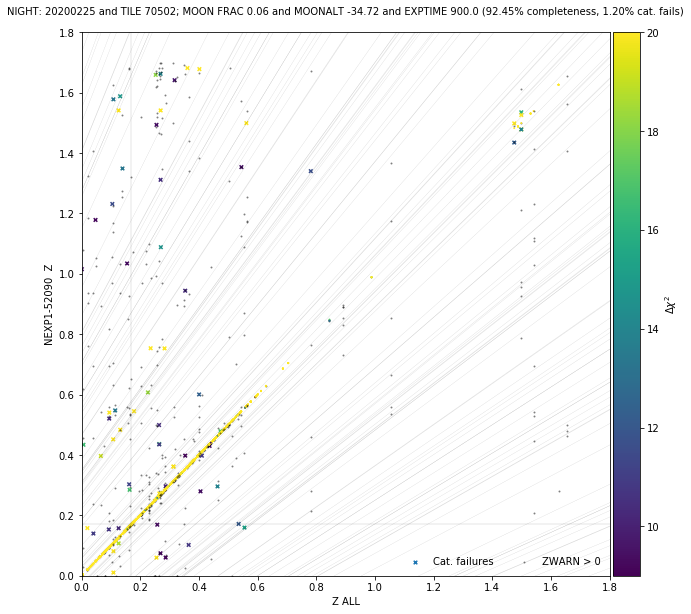

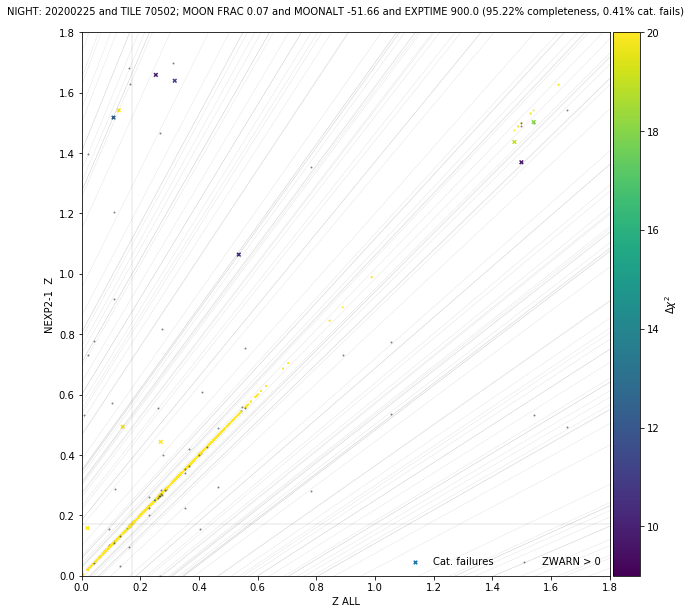

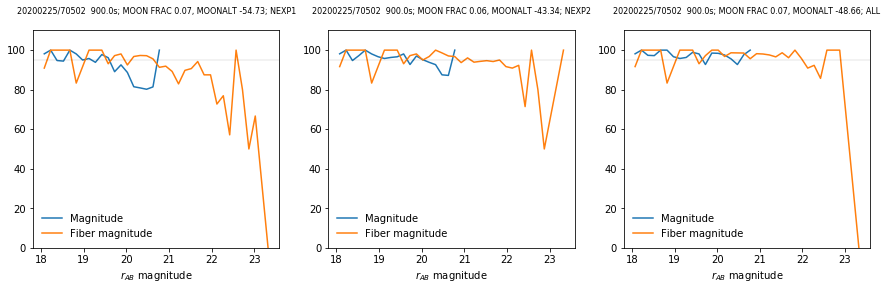

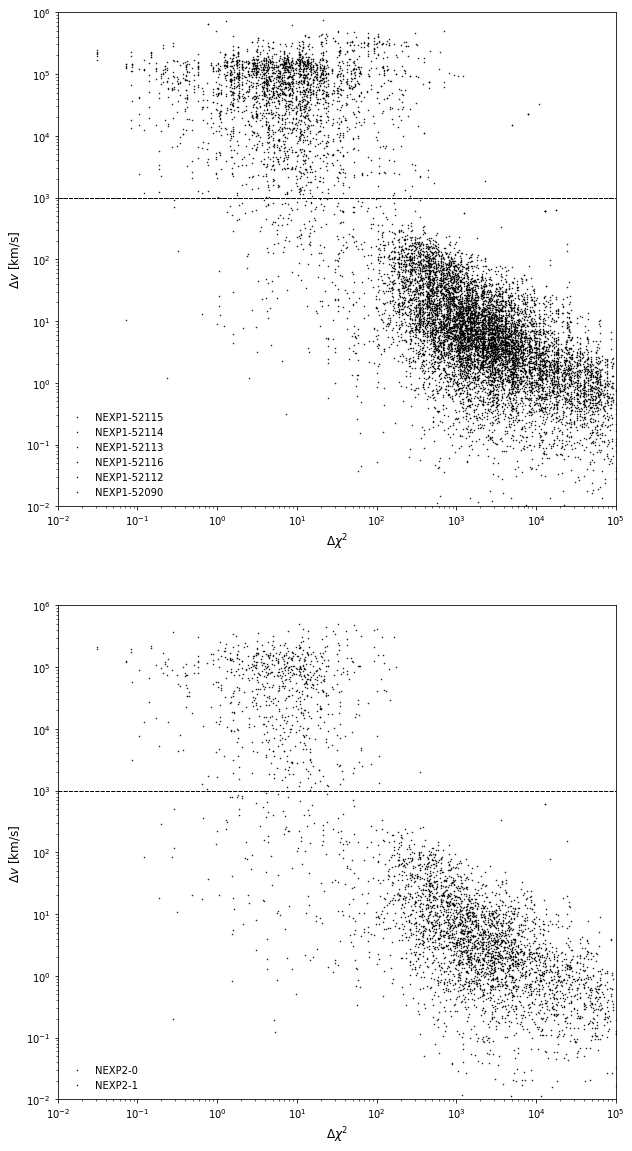

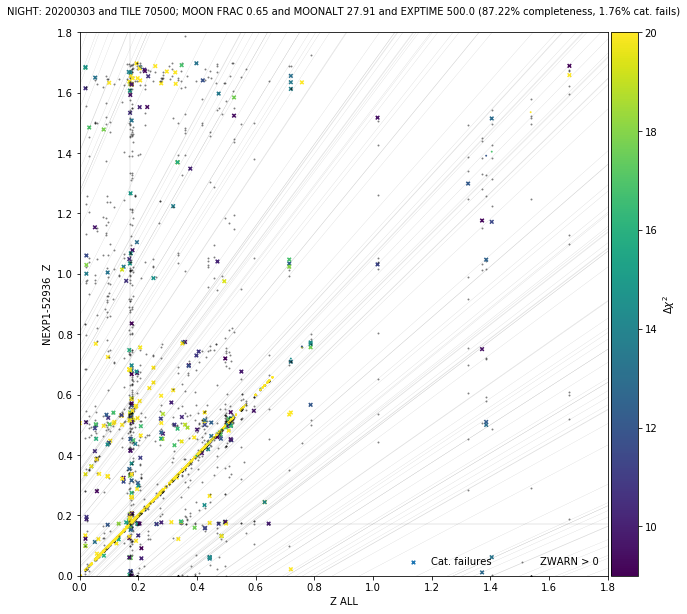

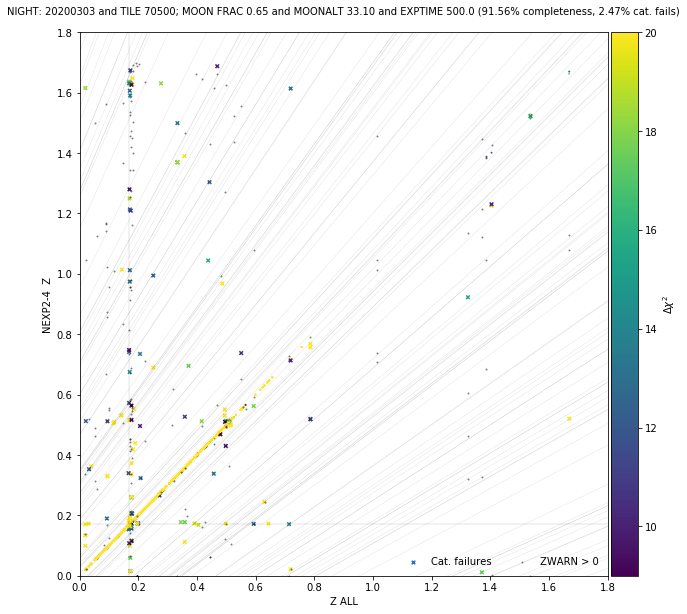

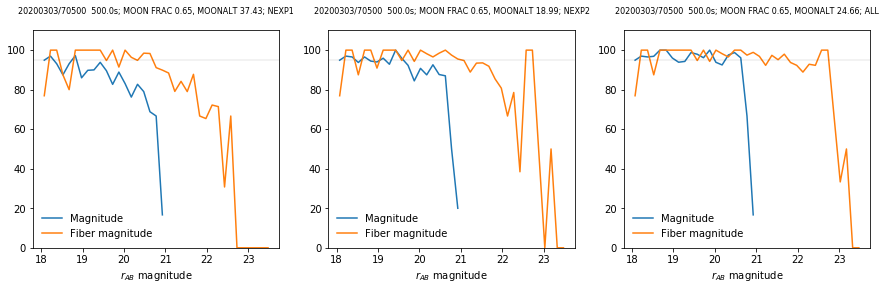

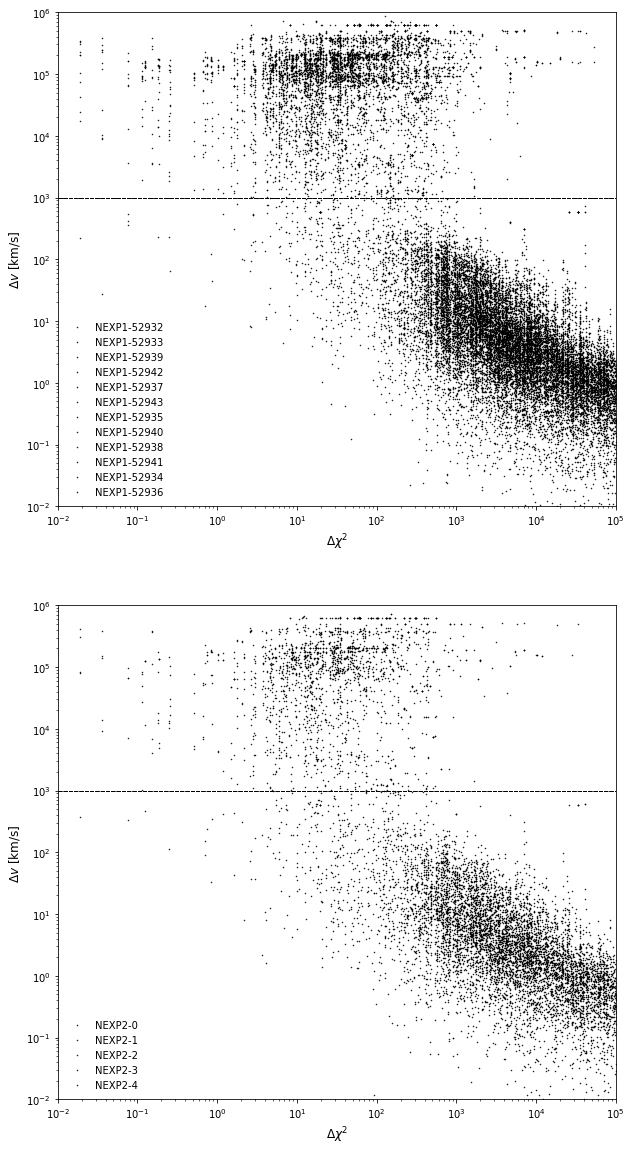

In [94]:
ids     = {}

samples = [samples[0], samples[-1]]

for night, tile in samples:
  ids[night] = plot_all(tile, night, completeness=True, deltav=False)

odict_keys(['NEXP1-52115', 'NEXP1-52114', 'NEXP1-52113', 'NEXP1-52116', 'NEXP1-52112', 'NEXP1-52090', 'NEXP2-0', 'NEXP2-1', 'ALL-NEXP6'])


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_inst

odict_keys(['NEXP1-52932', 'NEXP1-52933', 'NEXP1-52939', 'NEXP1-52942', 'NEXP1-52937', 'NEXP1-52943', 'NEXP1-52935', 'NEXP1-52940', 'NEXP1-52938', 'NEXP1-52941', 'NEXP1-52934', 'NEXP1-52936', 'NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL-NEXP12'])


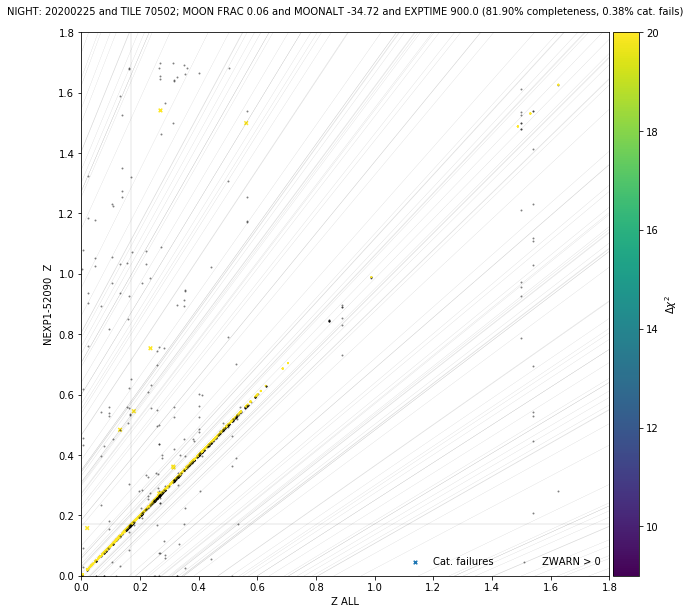

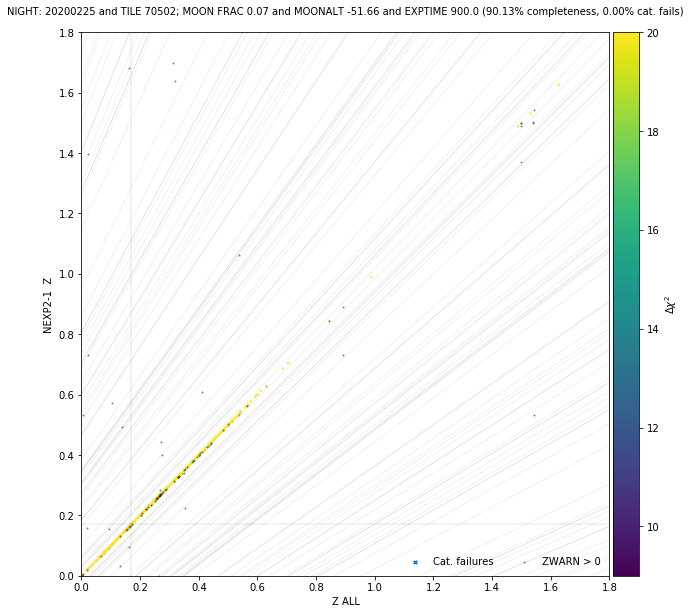

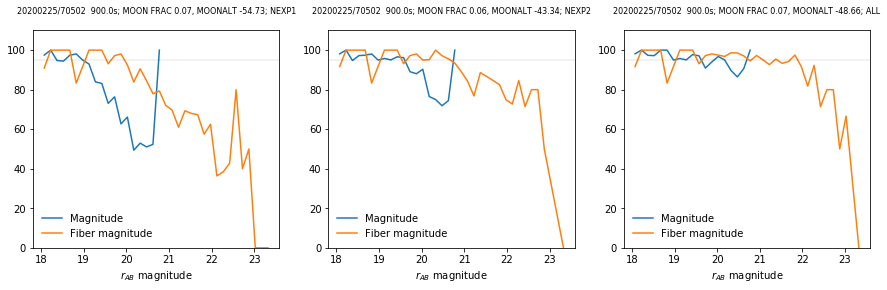

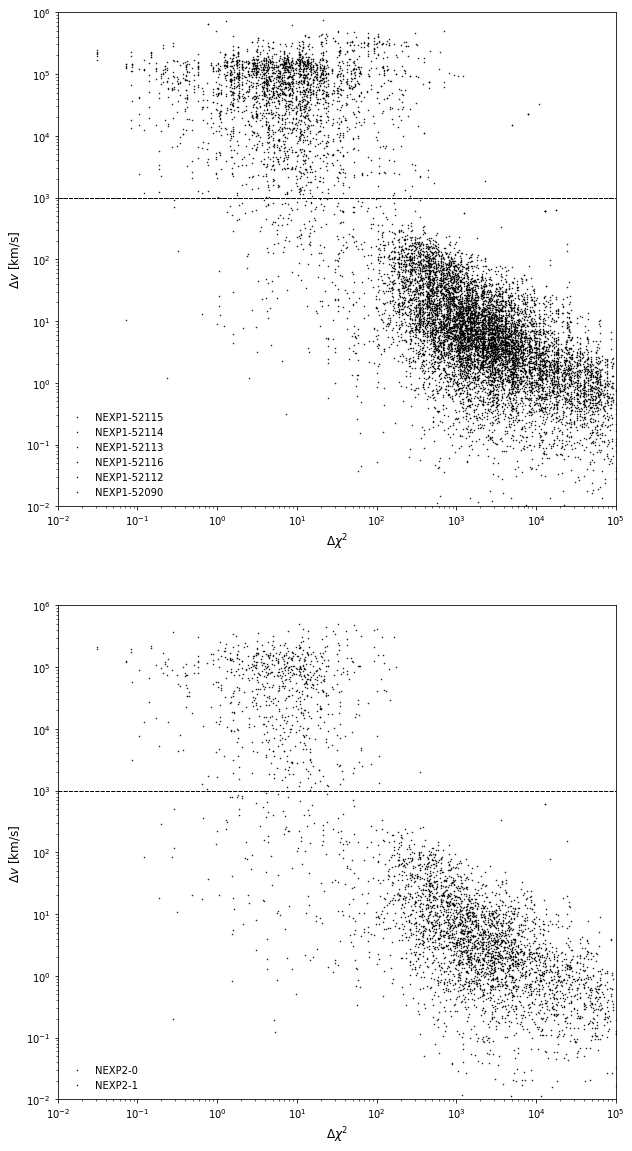

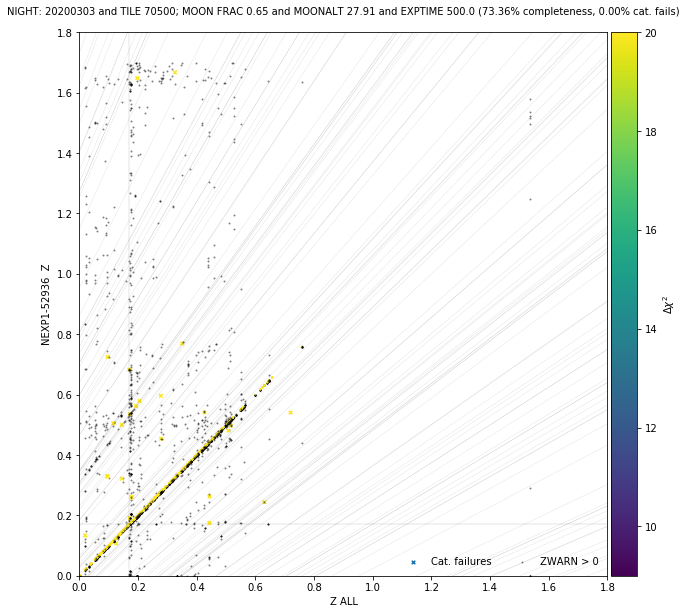

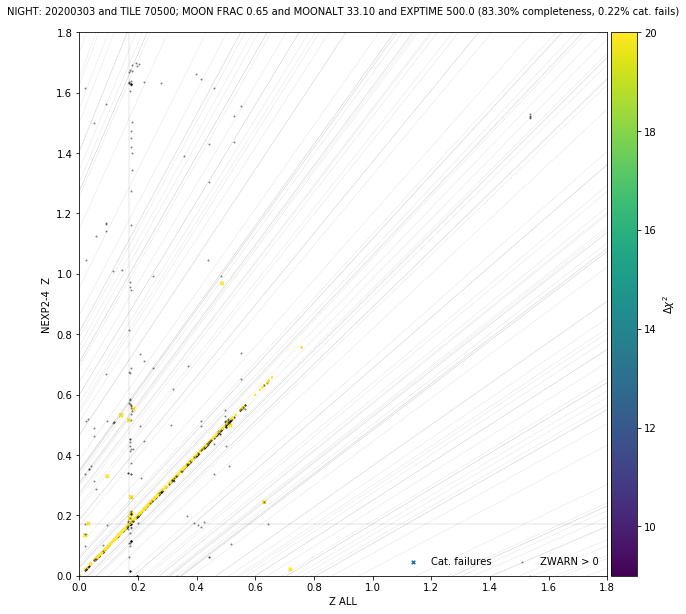

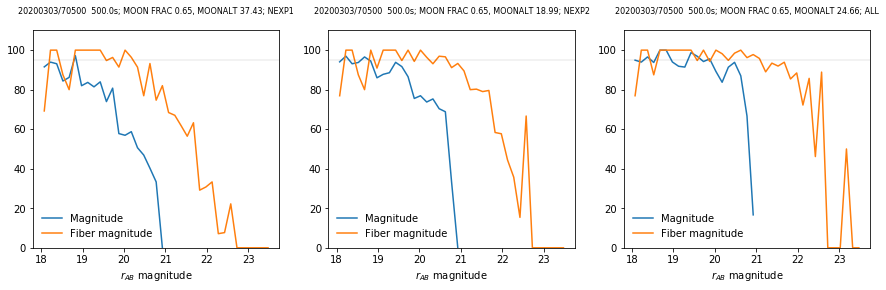

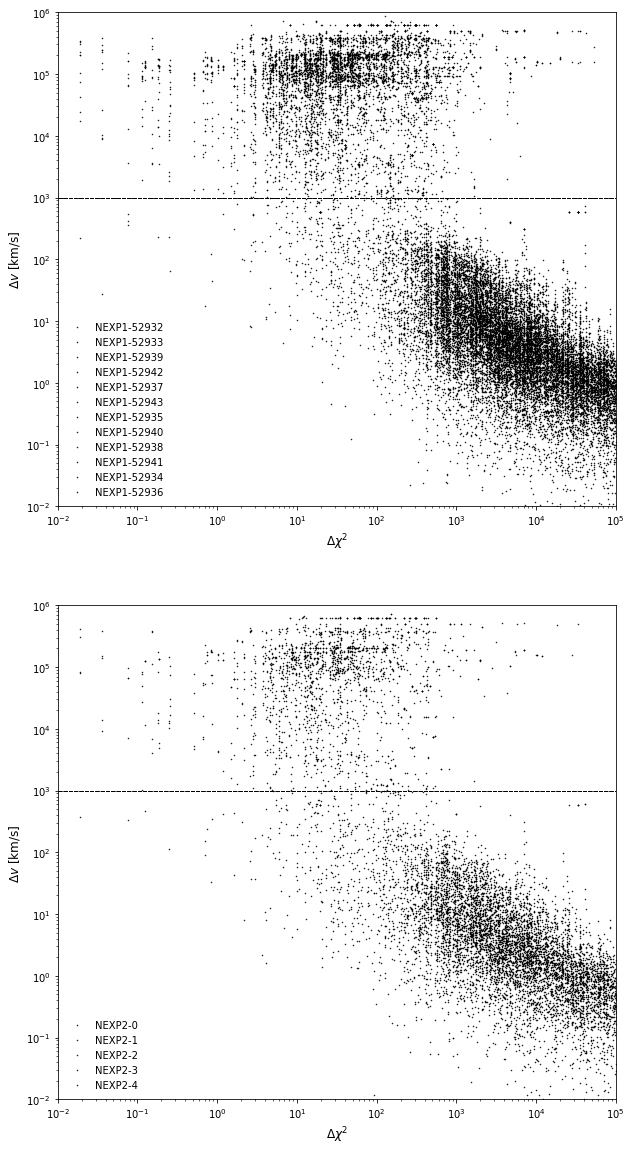

In [95]:
ids     = {}

samples = [samples[0], samples[-1]]

for night, tile in samples:
  ids[night] = plot_all(tile, night, completeness=True, deltav=False, dX2=50.0)

In [ ]:
for night, tile in samples:
  for key in results[tile][night].keys():
    print(key)

In [ ]:
for night, tile in samples:
  for key in results[tile][night].keys():
    if (key[0] == 'A') | (key.split('-')[0] == 'NEXP4'):
        continue

    keep                          = results[tile][night][key]
    _all                          = [x for x in results[tile][night].keys() if x[0] == 'A'][0]

    _                             = ids[night]
    
    fail_ids                      = _[key.split('-')[0]][key]
    
    if len(fail_ids) == 0:
        continue
    
    for petal in [0,3,6,7,9]: 
      coadd_path                  = results[tile][night][key]['coadds_paths'][petal]
      zbest_path                  = results[tile][night][key]['zbests_paths'][petal]

      _all_coadd_path             = results[tile][night][_all]['coadds_paths'][petal]
      _all_zbest_path             = results[tile][night][_all]['zbests_paths'][petal]
        
      zbest                       = Table(fits.open(zbest_path)[1].data)
      coadds                      = Table(fits.open(coadd_path)[1].data)
        
      _all_zbest                  = Table(fits.open(_all_zbest_path)[1].data)
      
      # failures                  = np.isin(zbest['TARGETID'], fail_ids) & (coadds['PETAL_LOC'] == petal) & (zbest['DELTACHI2'] > 20.)   
      failures                    = np.isin(zbest['TARGETID'], fail_ids) & (coadds['PETAL_LOC'] == petal) & (_all_zbest['DELTACHI2'] > 20.) 
      failures                    = zbest['TARGETID'][failures]
    
      if len(failures) > 0:    
        spectra                   = desispec.io.read_spectra(coadd_path)
        spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
        
        sp_single_exp             = spectra.select(targets=failures)

        plotframes.plotspectra(sp_single_exp,\
                               zcatalog=zbest,\
                               notebook=False,\
                               with_coaddcam=False,\
                               with_thumb_tab=False,\
                               title='{}_{}_{}_{}_catfails'.format(tile, night, petal, key),\
                               html_dir='/global/homes/m/mjwilson/www/MINISV')
        
        print('{} failures.  Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_{}_{}_{}_{}_catfails.html'.format(len(failures), tile, night, petal, key))
        
        _ = os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')
        
        spectra                   = desispec.io.read_spectra(_all_coadd_path)
        spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
        
        sp_single_exp             = spectra.select(targets=failures)
        
        plotframes.plotspectra(sp_single_exp,\
                               zcatalog=_all_zbest,\
                               notebook=False,\
                               with_coaddcam=False,\
                               with_thumb_tab=False,\
                               title='{}_{}_{}_{}_truth'.format(tile, night, petal, key),\
                               html_dir='/global/homes/m/mjwilson/www/MINISV')
    
        print('Truth.  Plotting https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_{}_{}_{}_{}_truth.html'.format(tile, night, petal, key))
    
        _ = os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')
    
        break
    
      else:
        pass

_ = os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')

##  Done.